## Materyal

Bu proje kapsamƒ±nda kullanƒ±lan veri seti, **"T√ºrk√ße Sosyal Medya Payla≈üƒ±m Veri Seti"** olarak adlandƒ±rƒ±lmaktadƒ±r. Veri seti, sosyal medya platformlarƒ±ndan toplanan T√ºrk√ße metinlerden olu≈ümaktadƒ±r. Ama√ß, sosyal medya payla≈üƒ±mlarƒ±nda **saldƒ±rganlƒ±k**, **nefret s√∂ylemi** veya **olumlu/olumsuz duygu analizi** gibi durumlarƒ± analiz edebilecek bir makine √∂ƒürenmesi modeli geli≈ütirmektir.

Veri seti **11119 satƒ±rdan** ve **2 s√ºtundan** olu≈ümaktadƒ±r:
- `Tip`: Payla≈üƒ±mƒ±n duygusal sƒ±nƒ±fƒ± ("Pozitif" veya "Negatif"),
- `Payla≈üƒ±m`: Payla≈üƒ±mƒ±n kendisi (metin).

Veri anonimle≈ütirilmi≈ü sosyal medya verileri √ºzerinden olu≈üturulmu≈ü olup, eƒüitim ve ara≈ütƒ±rma ama√ßlƒ± kullanƒ±lmaktadƒ±r.


In [19]:
# Veri i≈üleme
import pandas as pd
import numpy as np

# G√∂rselle≈ütirme
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Makine √∂ƒürenmesi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# Metin temizleme
import re

In [50]:
# Veri setini y√ºkleyelim
try:
    df = pd.read_csv("newcsv.csv", encoding='utf-8-sig', quotechar='"', engine="python")
except UnicodeDecodeError:
    df = pd.read_csv("newcsv.csv", encoding='ISO-8859-9', quotechar='"', engine="python")


# Veri setinin ilk birka√ß satƒ±rƒ±na g√∂z atalƒ±m
df.head()

# Veri seti hakkƒ±nda genel bilgiler
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11119 entries, 0 to 11118
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tip       11119 non-null  object
 1   Payla≈üƒ±m  11117 non-null  object
dtypes: object(2)
memory usage: 173.9+ KB
None


In [21]:
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11119 entries, 0 to 11118
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tip       11119 non-null  object
 1   Payla≈üƒ±m  11117 non-null  object
dtypes: object(2)
memory usage: 173.9+ KB


Tip         Payla≈üƒ±m
count     11119            11117
unique        2            11005
top     Pozitif  seni √∂ld√ºr√ºr√ºm 
freq       6115                3

### Describe Yorumlarƒ±:
- `Tip` s√ºtununda 2 farklƒ± sƒ±nƒ±f var: "Pozitif" ve "Negatif".
- Pozitif sƒ±nƒ±fƒ± 6115 √∂rnek ile veri setinde √ßoƒüunlukta.
- `Payla≈üƒ±m` s√ºtununda 11005 farklƒ± metin var, bazƒ± tekrar eden veriler mevcut.
- `Payla≈üƒ±m` s√ºtununda 2 eksik kayƒ±t bulunmaktadƒ±r.


In [22]:
# Eksik veri kontrol√º
df.isnull().sum()


Tip         0
Payla≈üƒ±m    2
dtype: int64

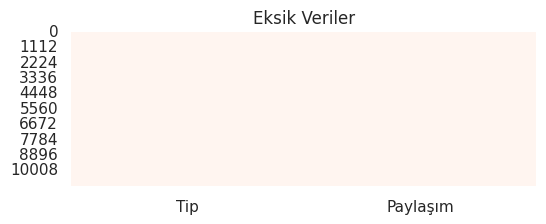

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 2))
sns.heatmap(df.isnull(), cbar=False, cmap="Reds")
plt.title("Eksik Veriler")
plt.show()


In [24]:
df = df.dropna(subset=['Payla≈üƒ±m'])


In [25]:
df.isnull().sum()


Tip         0
Payla≈üƒ±m    0
dtype: int64

In [26]:
df['Tip'].value_counts()


Tip
Pozitif    6113
Negatif    5004
Name: count, dtype: int64

In [27]:
df.loc[:, 'Tip'] = df['Tip'].str.lower().str.capitalize()


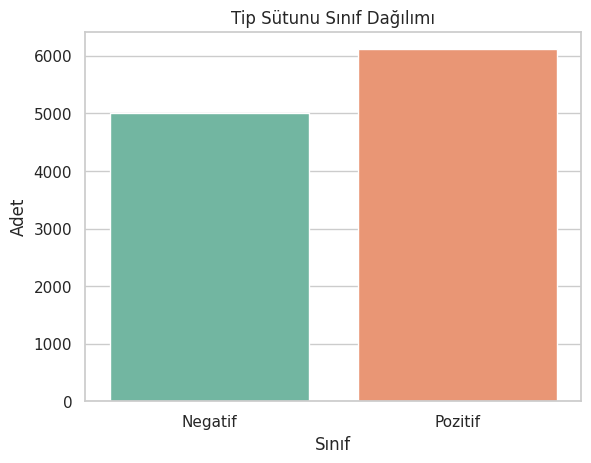

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='Tip', hue='Tip', palette='Set2', legend=False)
plt.title("Tip S√ºtunu Sƒ±nƒ±f Daƒüƒ±lƒ±mƒ±")
plt.xlabel("Sƒ±nƒ±f")
plt.ylabel("Adet")
plt.show()


### Ayrƒ±k Veri Analizi Sonu√ßlarƒ±:

- `Tip` s√ºtununda iki sƒ±nƒ±f olduƒüu g√∂r√ºl√ºyor: "Pozitif" ve "Negatif".
- Sƒ±nƒ±f daƒüƒ±lƒ±mƒ± dengesiz olabilir. Bu durum bazƒ± algoritmalar i√ßin √∂nemli olabilir (√∂rneƒüin: F1-score tercih sebebi olabilir).
- Verilerde k√º√ß√ºk/b√ºy√ºk harf farkƒ± giderildi ve tek tip hale getirildi.


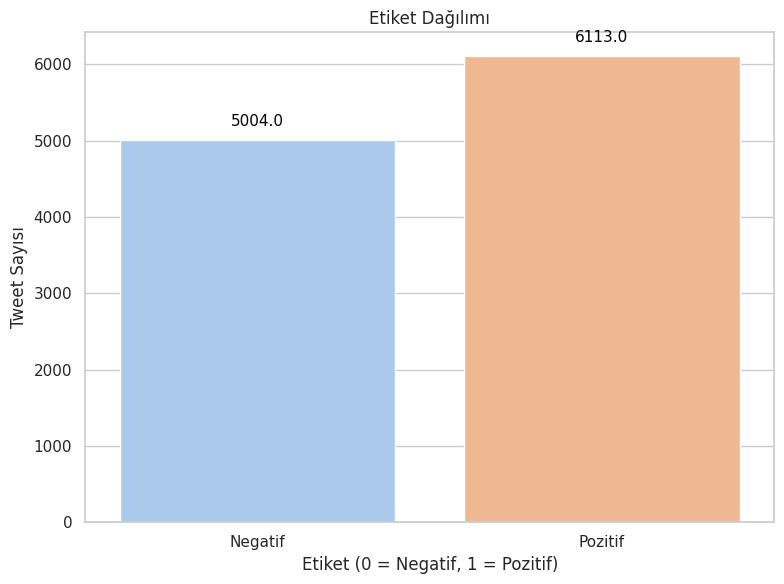

In [29]:
# Etiket daƒüƒ±lƒ±mƒ±
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Tip', data=df, palette='pastel', hue='Tip')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=11, color='black', xytext=(0, 8), textcoords='offset points')
plt.title("Etiket Daƒüƒ±lƒ±mƒ±")
plt.xlabel("Etiket (0 = Negatif, 1 = Pozitif)")
plt.ylabel("Tweet Sayƒ±sƒ±")
plt.tight_layout()
plt.show()

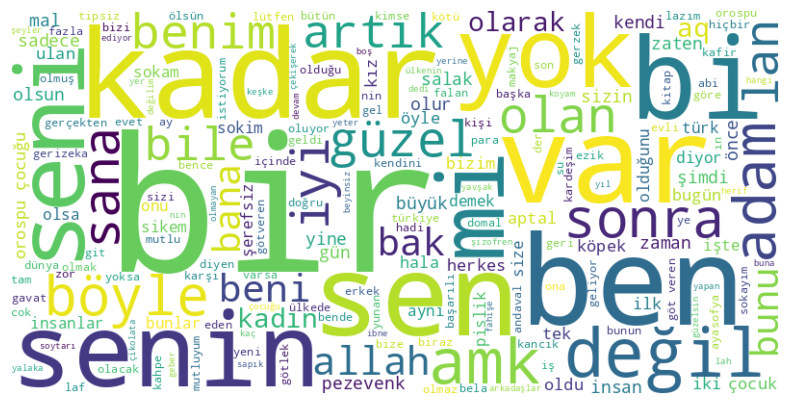

In [30]:
# Kelime bulutu
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['Payla≈üƒ±m']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [31]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['Payla≈üƒ±m'])
y = df['Tip']

# En iyi 500 √∂zelliƒüi se√ßelim
from sklearn.feature_selection import SelectKBest, chi2
X_new = SelectKBest(chi2, k=500).fit_transform(X, y)



In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)



In [33]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"--- {name} ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


--- Logistic Regression ---
Confusion Matrix:
[[ 724  283]
 [  89 1128]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.89      0.72      0.80      1007
     Pozitif       0.80      0.93      0.86      1217

    accuracy                           0.83      2224
   macro avg       0.84      0.82      0.83      2224
weighted avg       0.84      0.83      0.83      2224

--- Random Forest ---
Confusion Matrix:
[[ 742  265]
 [ 147 1070]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.83      0.74      0.78      1007
     Pozitif       0.80      0.88      0.84      1217

    accuracy                           0.81      2224
   macro avg       0.82      0.81      0.81      2224
weighted avg       0.82      0.81      0.81      2224

--- SVM ---
Confusion Matrix:
[[ 739  268]
 [  85 1132]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.90  

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# F1 skorunu string sƒ±nƒ±flarla √ßalƒ±≈üacak ≈üekilde ayarlayalƒ±m
f1_scorer = make_scorer(f1_score, pos_label='Pozitif')

# Hiperparametre grid'leri
param_grid_lr = {'C': [0.1, 1, 10]}
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [None, 10]}
param_grid_svc = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

grids = {
    "Logistic Regression": (LogisticRegression(max_iter=1000), param_grid_lr),
    "Random Forest": (RandomForestClassifier(), param_grid_rf),
    "SVM": (SVC(), param_grid_svc)
}

best_models = {}

for name, (model, params) in grids.items():
    grid = GridSearchCV(model, params, cv=5, scoring=f1_scorer)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    print(f"{name} i√ßin en iyi parametreler: {grid.best_params_}")
    print(f"{name} i√ßin en iyi F1 skoru: {grid.best_score_:.4f}")

    if name == "Logistic Regression":
        print(f"Logistic Regression i√ßin en iyi C deƒüeri: {grid.best_params_['C']}")
    elif name == "Random Forest":
        print(f"Random Forest i√ßin en iyi n_estimators: {grid.best_params_['n_estimators']}, max_depth: {grid.best_params_['max_depth']}")
    elif name == "SVM":
        print(f"SVM i√ßin en iyi C deƒüeri: {grid.best_params_['C']}, kernel: {grid.best_params_['kernel']}")

    print("="*50)


Logistic Regression i√ßin en iyi parametreler: {'C': 10}
Logistic Regression i√ßin en iyi F1 skoru: 0.8724
Logistic Regression i√ßin en iyi C deƒüeri: 10
Random Forest i√ßin en iyi parametreler: {'max_depth': None, 'n_estimators': 100}
Random Forest i√ßin en iyi F1 skoru: 0.8442
Random Forest i√ßin en iyi n_estimators: 100, max_depth: None
SVM i√ßin en iyi parametreler: {'C': 1, 'kernel': 'rbf'}
SVM i√ßin en iyi F1 skoru: 0.8697
SVM i√ßin en iyi C deƒüeri: 1, kernel: rbf


In [17]:
# Hiperparametre optimizasyonu
from sklearn.model_selection import GridSearchCV

# Logistic Regression i√ßin
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='f1_macro')
grid_lr.fit(X_train, y_train)

# Random Forest i√ßin
param_grid_rf = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='f1_macro')
grid_rf.fit(X_train, y_train)

# SVM i√ßin
param_grid_svc = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']}
grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=5, scoring='f1_macro')
grid_svc.fit(X_train, y_train)

# Final modellerle deƒüerlendirme
from sklearn.metrics import classification_report, confusion_matrix

final_models = {
    "Logistic Regression": grid_lr.best_estimator_,
    "Random Forest": grid_rf.best_estimator_,
    "SVM": grid_svc.best_estimator_
}

for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n--- {name} ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

# Friedman testi ile istatistiksel kar≈üƒ±la≈ütƒ±rma
from sklearn.model_selection import cross_val_score
from scipy.stats import friedmanchisquare

lr_scores = cross_val_score(grid_lr.best_estimator_, X_train, y_train, cv=5, scoring='f1_macro')
rf_scores = cross_val_score(grid_rf.best_estimator_, X_train, y_train, cv=5, scoring='f1_macro')
svc_scores = cross_val_score(grid_svc.best_estimator_, X_train, y_train, cv=5, scoring='f1_macro')

stat, p = friedmanchisquare(lr_scores, rf_scores, svc_scores)
print(f"\nFriedman Testi Sonucu: p-deƒüeri = {p:.4f}")
if p < 0.05:
    print("Anlamlƒ± fark var: Algoritmalar istatistiksel olarak farklƒ±.")
else:
    print("Anlamlƒ± fark yok.")



--- Logistic Regression ---
Confusion Matrix:
[[ 747  260]
 [  91 1126]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.89      0.74      0.81      1007
     Pozitif       0.81      0.93      0.87      1217

    accuracy                           0.84      2224
   macro avg       0.85      0.83      0.84      2224
weighted avg       0.85      0.84      0.84      2224


--- Random Forest ---
Confusion Matrix:
[[ 747  260]
 [ 140 1077]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.84      0.74      0.79      1007
     Pozitif       0.81      0.88      0.84      1217

    accuracy                           0.82      2224
   macro avg       0.82      0.81      0.82      2224
weighted avg       0.82      0.82      0.82      2224


--- SVM ---
Confusion Matrix:
[[ 746  261]
 [  91 1126]]
Classification Report:
              precision    recall  f1-score   support

     Negatif       0.8

In [18]:
from sklearn.metrics import make_scorer, f1_score

# Pozitif sƒ±nƒ±fƒ± belirterek √∂zel bir scorer tanƒ±mlƒ±yoruz
f1_scorer = make_scorer(f1_score, pos_label='Pozitif')

# Her model i√ßin √ßapraz doƒürulama f1 skorlarƒ±nƒ± hesaplƒ±yoruz
for name, model in best_models.items():
    scores = cross_val_score(model, X_new, y, cv=5, scoring=f1_scorer)
    print(f"{name} √ßapraz doƒürulama F1 skoru ortalama: {np.mean(scores):.4f}")


Logistic Regression √ßapraz doƒürulama F1 skoru ortalama: 0.8408
Random Forest √ßapraz doƒürulama F1 skoru ortalama: 0.8084
SVM √ßapraz doƒürulama F1 skoru ortalama: 0.8402


In [35]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel, wilcoxon

# f1 skorunu, 'Pozitif' sƒ±nƒ±fƒ± pozitif sƒ±nƒ±f olarak belirterek tanƒ±mla
f1_scorer = make_scorer(f1_score, pos_label='Pozitif')

# Logistic Regression ve Random Forest i√ßin F1 skorlarƒ±nƒ± yeniden hesapla
scores_lr = cross_val_score(best_models["Logistic Regression"], X_new, y, cv=5, scoring=f1_scorer)
scores_rf = cross_val_score(best_models["Random Forest"], X_new, y, cv=5, scoring=f1_scorer)

# Paired t-testi
t_stat, p_value = ttest_rel(scores_lr, scores_rf)
print(f"Logistic Regression ve Random Forest arasƒ±nda Paired t-testi: p-deƒüeri = {p_value}")

# Wilcoxon testi
w_stat, p_value_w = wilcoxon(scores_lr, scores_rf)
print(f"Logistic Regression ve Random Forest arasƒ±nda Wilcoxon testi: p-deƒüeri = {p_value_w}")


Logistic Regression ve Random Forest arasƒ±nda Paired t-testi: p-deƒüeri = 0.0013661322284673082
Logistic Regression ve Random Forest arasƒ±nda Wilcoxon testi: p-deƒüeri = 0.0625


In [87]:
y_train_pred = best_models["Logistic Regression"].predict(X_train)
print("En ƒ∞yi Model (Eƒüitim Seti) Sƒ±nƒ±flandƒ±rma Raporu:")
print(classification_report(y_train, y_train_pred))

y_test_pred = best_models["Logistic Regression"].predict(X_test)
print("En ƒ∞yi Model (Test Seti) Sƒ±nƒ±flandƒ±rma Raporu:")
print(classification_report(y_test, y_test_pred))


En ƒ∞yi Model (Eƒüitim Seti) Sƒ±nƒ±flandƒ±rma Raporu:
              precision    recall  f1-score   support

     Negatif       0.91      0.78      0.84      3997
     Pozitif       0.84      0.94      0.88      4896

    accuracy                           0.87      8893
   macro avg       0.87      0.86      0.86      8893
weighted avg       0.87      0.87      0.86      8893

En ƒ∞yi Model (Test Seti) Sƒ±nƒ±flandƒ±rma Raporu:
              precision    recall  f1-score   support

     Negatif       0.89      0.74      0.81      1007
     Pozitif       0.81      0.93      0.87      1217

    accuracy                           0.84      2224
   macro avg       0.85      0.83      0.84      2224
weighted avg       0.85      0.84      0.84      2224



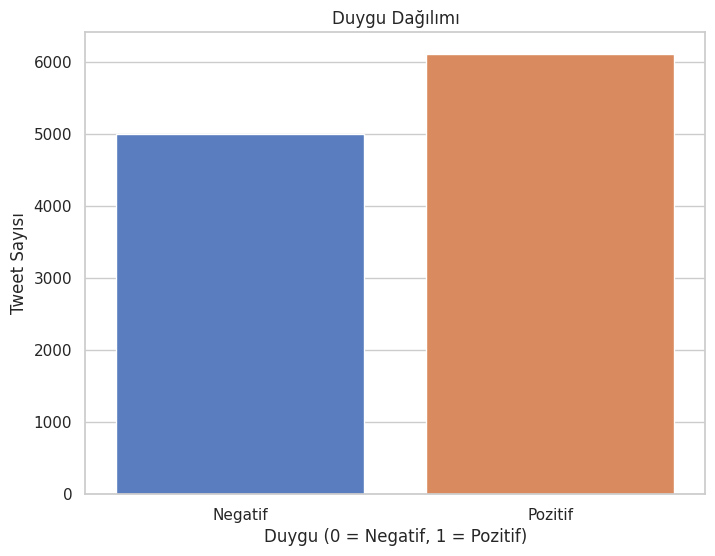

In [37]:
# Grafik i√ßin d√ºzenlemeleri yapƒ±yoruz
plt.figure(figsize=(8, 6))

# Hue parametresi eklenmi≈ü versiyon
sns.countplot(x='Tip', data=df, hue='Tip', palette='muted', legend=False)

plt.title("Duygu Daƒüƒ±lƒ±mƒ±")
plt.xlabel("Duygu (0 = Negatif, 1 = Pozitif)")
plt.ylabel("Tweet Sayƒ±sƒ±")
plt.show()


Pozitif tweet sayƒ±sƒ±: 6113
Negatif tweet sayƒ±sƒ±: 5004


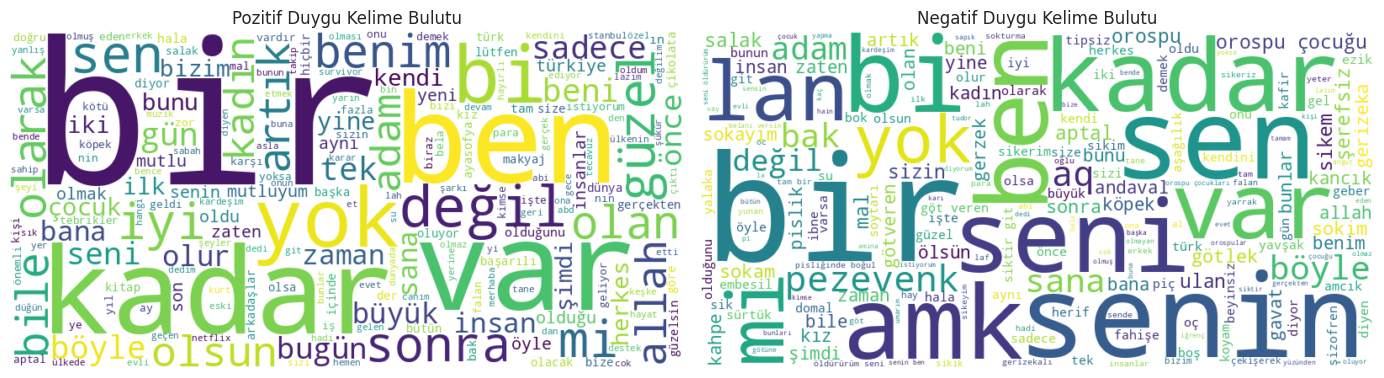

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 'Paylasim' yerine 'Payla≈üƒ±m' kullanƒ±lacak ≈üekilde uyumlu hale getirdik
if 'Paylasim' in df.columns and 'Payla≈üƒ±m' not in df.columns:
    df.rename(columns={'Paylasim': 'Payla≈üƒ±m'}, inplace=True)

# Eksik verileri temizledik
df = df.dropna(subset=['Payla≈üƒ±m', 'Tip'])

# Tip s√ºtununu sayƒ±ya √ßevirdik ('Pozitif' ‚Üí 1, 'Negatif' ‚Üí 0)
df['Tip'] = df['Tip'].map({'Pozitif': 1, 'Negatif': 0})

# Pozitif ve negatif tweet'leri filtrele
positive_tweets = df[df['Tip'] == 1]
negative_tweets = df[df['Tip'] == 0]

print(f"Pozitif tweet sayƒ±sƒ±: {len(positive_tweets)}")
print(f"Negatif tweet sayƒ±sƒ±: {len(negative_tweets)}")

# Kelime bulutlarƒ±nƒ± olu≈üturduk ve g√∂rselle≈ütirdik
if len(positive_tweets) > 0 and len(negative_tweets) > 0:
    positive_words = " ".join(positive_tweets['Payla≈üƒ±m'].astype(str))
    negative_words = " ".join(negative_tweets['Payla≈üƒ±m'].astype(str))

    positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_words)
    negative_wc = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(positive_wc, interpolation='bilinear')
    axes[0].axis("off")
    axes[0].set_title("Pozitif Duygu Kelime Bulutu")
    axes[1].imshow(negative_wc, interpolation='bilinear')
    axes[1].axis("off")
    axes[1].set_title("Negatif Duygu Kelime Bulutu")
    plt.tight_layout()
    plt.show()
else:
    print("Pozitif veya negatif tweet verisi bulunamadƒ±.")




In [40]:
missing = df.isnull().sum()
df.fillna(df.mean(numeric_only=True), inplace=True)

In [41]:
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

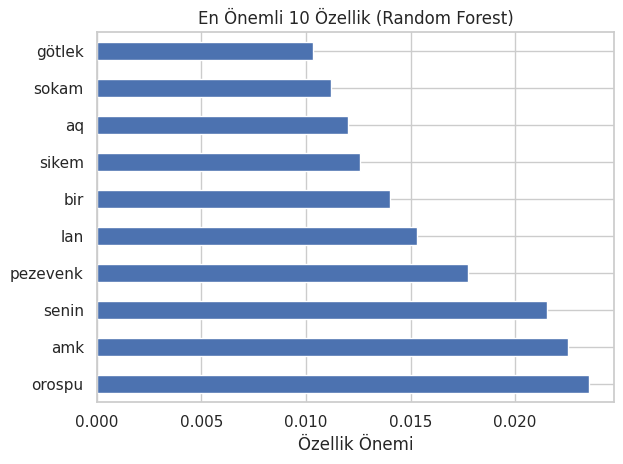

In [42]:
# X, TF-IDF veya ba≈üka bir vekt√∂rle≈ütiriciden geliyorsa, onu DataFrame'e d√∂n√º≈üt√ºrelim
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Random Forest modelini eƒüitelim
rf = RandomForestClassifier()
rf.fit(X_df, y)

# √ñzellik √∂nemlerini alalƒ±m
importances = pd.Series(rf.feature_importances_, index=X_df.columns)

# En y√ºksek 10 √∂zelliƒüi g√∂rselle≈ütirelim
importances.nlargest(10).plot(kind='barh')
plt.title("En √ñnemli 10 √ñzellik (Random Forest)")
plt.xlabel("√ñzellik √ñnemi")
plt.tight_layout()
plt.show()


<ipython-input-51-9e1a213abb59>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scores, y=top_words, palette="viridis")


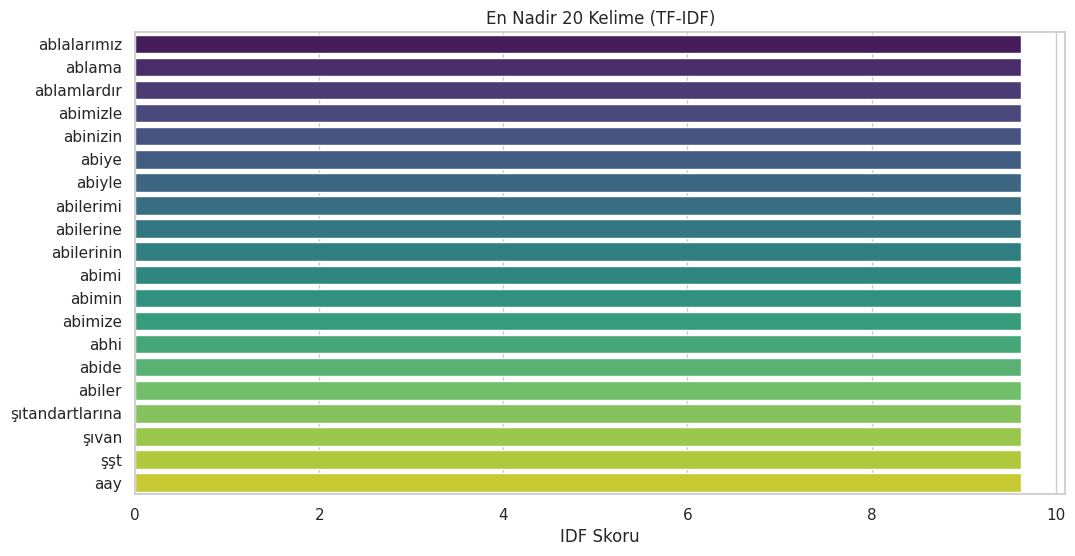

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sadece dolu olan "Payla≈üƒ±m" verilerini al
corpus = df['Payla≈üƒ±m'].dropna().astype(str).tolist()

# TF-IDF hesapla
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

# √ñzellik isimleri ve IDF skorlarƒ±
feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_

# En y√ºksek IDF (en nadir) 20 kelimeyi se√ß
top_n = 20
sorted_idx = np.argsort(idf_scores)[-top_n:]
top_words = feature_names[sorted_idx]
top_scores = idf_scores[sorted_idx]

# G√∂rselle≈ütir
plt.figure(figsize=(12, 6))
sns.barplot(x=top_scores, y=top_words, palette="viridis")
plt.xlabel("IDF Skoru")
plt.title(f"En Nadir {top_n} Kelime (TF-IDF)")
plt.show()





In [52]:
from sklearn.model_selection import GridSearchCV
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [None, 10]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10], 'n_estimators': [50, 100]},
             scoring='accuracy')

In [53]:
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel
scores_rf = cross_val_score(RandomForestClassifier(), X, y, cv=5)
scores_svm = cross_val_score(SVC(), X, y, cv=5)
t_stat, p_value = ttest_rel(scores_rf, scores_svm)

In [54]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = grid_rf.predict(X_test)
confusion_matrix(y_test, y_pred)
classification_report(y_test, y_pred)

'              precision    recall  f1-score   support\n\n     Negatif       0.84      0.74      0.79      1007\n     Pozitif       0.80      0.88      0.84      1217\n\n    accuracy                           0.82      2224\n   macro avg       0.82      0.81      0.81      2224\nweighted avg       0.82      0.82      0.82      2224\n'

In [ ]:
# Soru 1: Negatif i√ßerikli sosyal medya payla≈üƒ±mlarƒ±, belirli temalar (≈üiddet, √∂fke, hakaret vb.) etrafƒ±nda k√ºmelenebilir mi?
# Bu analizde, negatif olarak etiketlenmi≈ü sosyal medya metinleri √ºzerinde konu modelleme (LDA) uygulanacaktƒ±r.
# Ama√ß, hangi i√ßeriklerin baskƒ±n temalar etrafƒ±nda toplandƒ±ƒüƒ±nƒ± g√∂zlemlemektir.

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vekt√∂rle≈ütirme (temiz metinler)
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')  # <- bu satƒ±r d√ºzeltildi
X = vectorizer.fit_transform(negatif_df['Payla≈üƒ±m'].astype(str))

# LDA uygulama
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

# Temalarƒ± yazdƒ±ralƒ±m
feature_names = vectorizer.get_feature_names_out()
for index, topic in enumerate(lda.components_):
    print(f"K√ºme {index+1}: ", [feature_names[i] for i in topic.argsort()[-6:][::-1]])



K√ºme 1:  ['sen', 'bir', 'amk', 'lan', 'bi', 'var']
K√ºme 2:  ['bir', 'orospu', 'seni', 'bi', 'sen', 'senin']
K√ºme 3:  ['senin', 'bir', 'allah', 'kadar', 'seni', 'lan']


In [ ]:
# Soru 2: Pozitif ve negatif payla≈üƒ±mlar arasƒ±nda s√∂zc√ºk √ße≈üitliliƒüi (vocabulary richness) a√ßƒ±sƒ±ndan anlamlƒ± bir fark var mƒ±dƒ±r?
# Burada Type-Token Ratio (benzersiz kelime sayƒ±sƒ± / toplam kelime sayƒ±sƒ±) kar≈üƒ±la≈ütƒ±rƒ±lacaktƒ±r.
# ƒ∞statistiksel anlamlƒ±lƒ±k i√ßin t-testi uygulanacaktƒ±r.

In [58]:
# Her payla≈üƒ±mƒ±n kelime √ße≈üitliliƒüini (TTR) hesaplayalƒ±m
def calculate_ttr(text):
    tokens = str(text).split()
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)

df['TTR'] = df['Payla≈üƒ±m'].apply(calculate_ttr)


Pozitif ortalama TTR: 0.977
Negatif ortalama TTR: 0.981
p-deƒüeri: 0.0001


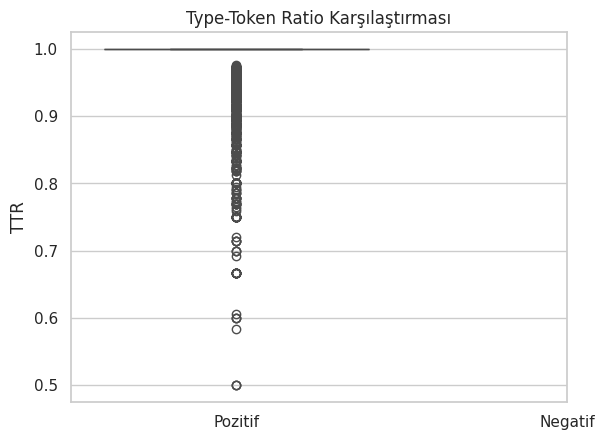

In [59]:
from scipy.stats import ttest_ind
import seaborn as sns

# Pozitif ve negatif TTR deƒüerlerini alalƒ±m
pozitif_TTR = df[df['Tip'] == 'Pozitif']['TTR']
negatif_TTR = df[df['Tip'] == 'Negatif']['TTR']

# t-testi
ttr_test = ttest_ind(pozitif_TTR.dropna(), negatif_TTR.dropna())
print(f"Pozitif ortalama TTR: {pozitif_TTR.mean():.3f}")
print(f"Negatif ortalama TTR: {negatif_TTR.mean():.3f}")
print(f"p-deƒüeri: {ttr_test.pvalue:.4f}")

# G√∂rselle≈ütirme
sns.boxplot(data=[pozitif_TTR, negatif_TTR])
plt.xticks([0, 1], ['Pozitif', 'Negatif'])
plt.title("Type-Token Ratio Kar≈üƒ±la≈ütƒ±rmasƒ±")
plt.ylabel("TTR")
plt.show()


In [77]:
# Soru 3: Negatif payla≈üƒ±mlar, pozitiflere g√∂re daha kƒ±sa c√ºmle yapƒ±sƒ±na mƒ± sahiptir?
# Her payla≈üƒ±mƒ±n kelime sayƒ±sƒ± √∂l√ß√ºl√ºp, iki grup kar≈üƒ±la≈ütƒ±rƒ±lacaktƒ±r. T-testi ile anlamlƒ±lƒ±k incelenecektir.

In [61]:
# Her payla≈üƒ±m i√ßin kelime sayƒ±sƒ± hesaplayalƒ±m
df["kelime_sayisi"] = df["Payla≈üƒ±m"].apply(lambda x: len(str(x).split()))


Pozitif ortalama uzunluk: 10.55
Negatif ortalama uzunluk: 9.51
p-deƒüeri: 0.0000


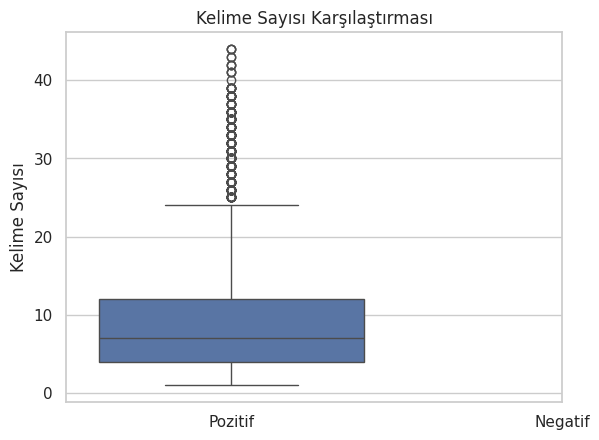

In [62]:
# Kelime sayƒ±sƒ± kar≈üƒ±la≈ütƒ±rmasƒ±nƒ± yapalƒ±m
pozitif_len = df[df['Tip'] == 'Pozitif']['kelime_sayisi']
negatif_len = df[df['Tip'] == 'Negatif']['kelime_sayisi']

length_test = ttest_ind(pozitif_len.dropna(), negatif_len.dropna())
print(f"Pozitif ortalama uzunluk: {pozitif_len.mean():.2f}")
print(f"Negatif ortalama uzunluk: {negatif_len.mean():.2f}")
print(f"p-deƒüeri: {length_test.pvalue:.4f}")

# G√∂rselle≈ütirelim
sns.boxplot(data=[pozitif_len, negatif_len])
plt.xticks([0, 1], ['Pozitif', 'Negatif'])
plt.title("Kelime Sayƒ±sƒ± Kar≈üƒ±la≈ütƒ±rmasƒ±")
plt.ylabel("Kelime Sayƒ±sƒ±")
plt.show()


In [76]:
# Geni≈ületilmi≈ü Tematik Sƒ±nƒ±flandƒ±rma
# Negatif duygulu sosyal medya payla≈üƒ±mlarƒ±nƒ±n i√ßeriklerine g√∂re a≈üaƒüƒ±daki tematik kategorilere atama yapƒ±yoruz:
# - Kadƒ±na ≈ûiddet ve Cinsiyet√ßilik
# - Bireysel Hakaret ve Zorbalƒ±k
# - Dini ve Milli Deƒüerlere Saldƒ±rƒ±
# - Toplumsal Ele≈ütiri ve G√ºvensizlik
# - Psikolojik √á√∂k√ºnt√º ve Umutsuzluk
# - Hayvan √úzerinden Hakaret/≈ûiddet
# - Cinsel ƒ∞ma ve K√ºf√ºr
# - Alaycƒ± Mizah ve Vulgarlƒ±k
# Her kategori belirli anahtar kelimelerle e≈üle≈ütirilir. Payla≈üƒ±mlarƒ±n i√ßeriklerinde bu kelimeler aranƒ±r.

In [63]:
# Kategorik anahtar kelimeleri
kategori_kelimeleri = {
    "Kadƒ±na ≈ûiddet ve Cinsiyet√ßilik": ['kadƒ±n', 'karƒ±', 'orospu', 'namus', 'tecav√ºz', 'iffet', 'kadƒ±nca'],
    "Bireysel Hakaret ve Zorbalƒ±k": ['salak', 'aptal', '≈üerefsiz', 'lan', 'beyinsiz', 'geri zekalƒ±', 'dangalak', 'mal'],
    "Dini ve Milli Deƒüerlere Saldƒ±rƒ±": ['allah', 'din', '≈üeriat', 'm√ºsl√ºman', 'imam', 'vatan', 'millet', 'ezan'],
    "Psikolojik √á√∂k√ºnt√º ve Umutsuzluk": ['√∂l√ºm', 'intihar', 'dayanamƒ±yorum', 'bittim', 'nefret ediyorum', 'iƒüren√ß', 'hayat'],
    "Hayvan √úzerinden Hakaret/≈ûiddet": ['k√∂pek', 'e≈üek', 'hayvan', 'sƒ±√ß', 'ƒ±sƒ±r', '√∂ld√ºr'],
    "Alaycƒ± Mizah ve Vulgarlƒ±k": ['aƒüzƒ±na sƒ±√ßayƒ±m', 'haha', 'dalga ge√ß', 'komik', 'neye g√ºld√ºm']
}


In [64]:
# Kategori atama fonksiyonu
def kategori_bul(metin):
    metin = str(metin).lower()
    kategoriler = []
    for kategori, kelimeler in kategori_kelimeleri.items():
        if any(anahtar in metin for anahtar in kelimeler):
            kategoriler.append(kategori)
    return kategoriler if kategoriler else ['Diƒüer']

# Sadece negatif payla≈üƒ±mlarƒ± alƒ±yoruz
negatif_df = df[df['Tip'] == 'Negatif'].copy()
negatif_df['Kategoriler'] = negatif_df['Payla≈üƒ±m'].apply(kategori_bul)

# Kategorilere g√∂re explode i≈ülemi
kategori_df = negatif_df.explode('Kategoriler')


<ipython-input-65-66bc9b79f655>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kategori_sayim.values, y=kategori_sayim.index, palette="magma")


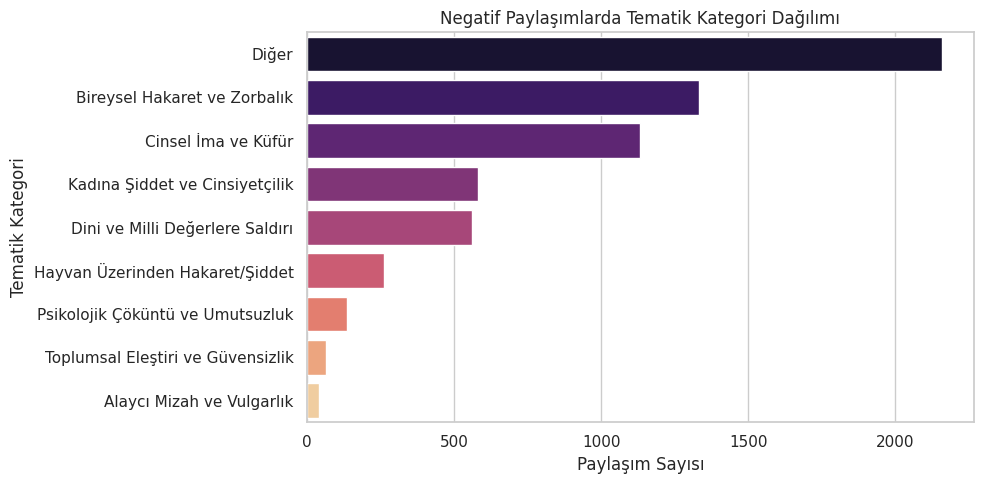

In [65]:
# Kategori frekanslarƒ±nƒ± hesaplƒ±yoruz
kategori_sayim = kategori_df['Kategoriler'].value_counts()

# G√∂rselle≈ütirme
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(x=kategori_sayim.values, y=kategori_sayim.index, palette="magma")
plt.title("Negatif Payla≈üƒ±mlarda Tematik Kategori Daƒüƒ±lƒ±mƒ±")
plt.xlabel("Payla≈üƒ±m Sayƒ±sƒ±")
plt.ylabel("Tematik Kategori")
plt.tight_layout()
plt.show()


In [66]:
# Her kategori i√ßin √∂rnek payla≈üƒ±m √ßekelim
ornekler = kategori_df.groupby("Kategoriler").apply(lambda x: x['Payla≈üƒ±m'].sample(1).values[0])
display(ornekler)


<ipython-input-66-90e4d78ce144>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ornekler = kategori_df.groupby("Kategoriler").apply(lambda x: x['Payla≈üƒ±m'].sample(1).values[0])


Kategoriler
Alaycƒ± Mizah ve Vulgarlƒ±k            kancƒ±k beyaztv ekibi i≈ü ba≈üƒ±nda akƒ±llarƒ±nca da...
Bireysel Hakaret ve Zorbalƒ±k         gerizekali amciklar sizce kralicemizin cembari...
Cinsel ƒ∞ma ve K√ºf√ºr                       we are turkish orospu √ßocuƒüu sikerim belanƒ± 
Dini ve Milli Deƒüerlere Saldƒ±rƒ±                   vicdansƒ±z allah senin belanƒ± versin 
Diƒüer                                mehmet metiner tarihte ≈üahsiyet var doƒürusu bi...
Hayvan √úzerinden Hakaret/≈ûiddet      devletime cumhurba≈ükanƒ±ma bayraƒüƒ±ma halkƒ±na se...
Kadƒ±na ≈ûiddet ve Cinsiyet√ßilik       ger√ßekten orospu √ßocuƒüu adi a≈üaƒüƒ±lƒ±k herif hak...
Psikolojik √á√∂k√ºnt√º ve Umutsuzluk                          aptal mƒ±sƒ±n sil iƒüren√ß ≈üeyi 
Toplumsal Ele≈ütiri ve G√ºvensizlik    bir bizim vergilerle beslerler bunlarƒ± ≈üimdi a...
dtype: object

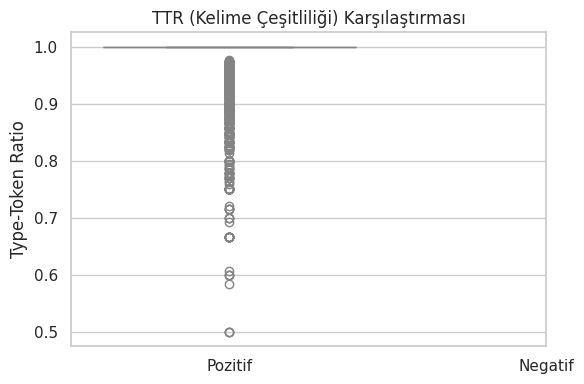

In [67]:
# TTR Boxplot: Pozitif vs Negatif payla≈üƒ±mlarda kelime √ße≈üitliliƒüi farkƒ±na bakalƒ±m
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(data=[pozitif_TTR, negatif_TTR], palette="coolwarm")
plt.xticks([0, 1], ['Pozitif', 'Negatif'])
plt.title("TTR (Kelime √áe≈üitliliƒüi) Kar≈üƒ±la≈ütƒ±rmasƒ±")
plt.ylabel("Type-Token Ratio")
plt.tight_layout()
plt.show()


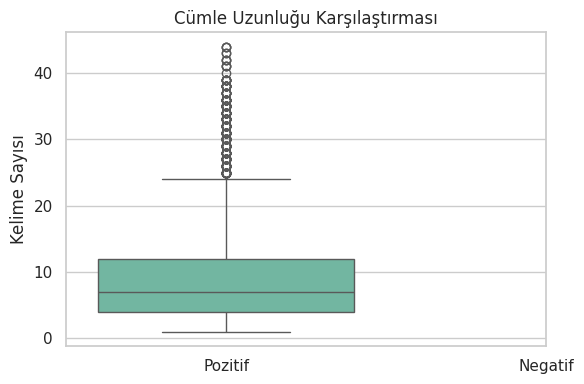

In [68]:
# C√ºmle uzunluƒüu kar≈üƒ±la≈ütƒ±rmasƒ±
plt.figure(figsize=(6, 4))
sns.boxplot(data=[pozitif_len, negatif_len], palette="Set2")
plt.xticks([0, 1], ['Pozitif', 'Negatif'])
plt.title("C√ºmle Uzunluƒüu Kar≈üƒ±la≈ütƒ±rmasƒ±")
plt.ylabel("Kelime Sayƒ±sƒ±")
plt.tight_layout()
plt.show()


<ipython-input-69-ded6d5076b22>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kategori_sayim.values, y=kategori_sayim.index, palette="flare")


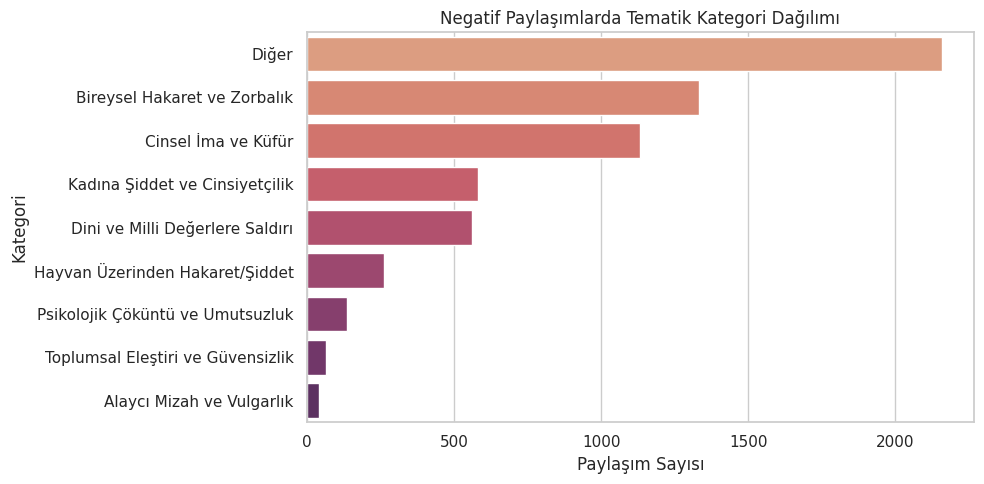

In [69]:
# Negatif payla≈üƒ±mlarƒ±n tematik daƒüƒ±lƒ±mƒ±
plt.figure(figsize=(10, 5))
sns.barplot(x=kategori_sayim.values, y=kategori_sayim.index, palette="flare")
plt.title("Negatif Payla≈üƒ±mlarda Tematik Kategori Daƒüƒ±lƒ±mƒ±")
plt.xlabel("Payla≈üƒ±m Sayƒ±sƒ±")
plt.ylabel("Kategori")
plt.tight_layout()
plt.show()


<ipython-input-70-b2a8d6f5d1db>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='rocket')


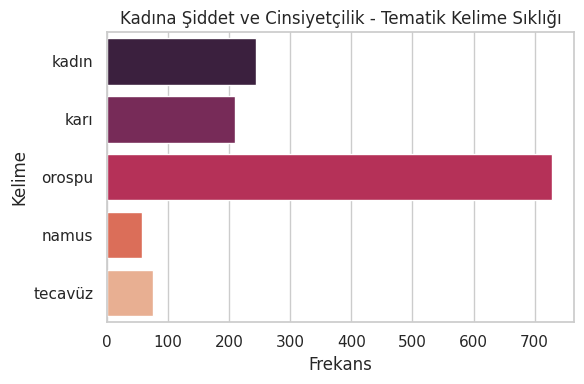

In [70]:
# Kadƒ±na ≈ûiddet temalƒ± √∂nemli kelimelerin frekansƒ±
kelimeler = ['kadƒ±n', 'karƒ±', 'orospu', 'namus', 'tecav√ºz']
frekanslar = [kategori_df['Payla≈üƒ±m'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='rocket')
plt.title("Kadƒ±na ≈ûiddet ve Cinsiyet√ßilik - Tematik Kelime Sƒ±klƒ±ƒüƒ±")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-78-b29690c6b268>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='crest')


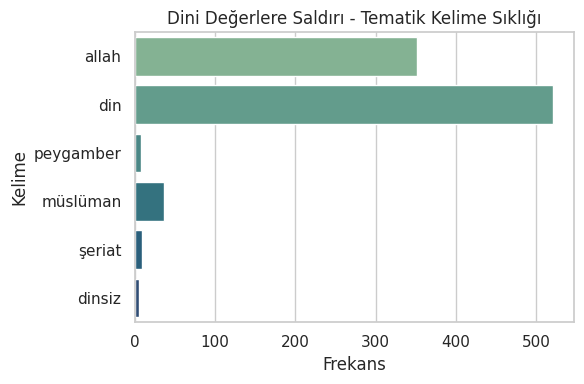

In [78]:
# Dini Deƒüerlere Saldƒ±rƒ± temalƒ± √∂nemli kelimelerin frekansƒ±
kelimeler = ['allah', 'din', 'peygamber', 'm√ºsl√ºman', '≈üeriat', 'dinsiz']
frekanslar = [kategori_df['Payla≈üƒ±m'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='crest')
plt.title("Dini Deƒüerlere Saldƒ±rƒ± - Tematik Kelime Sƒ±klƒ±ƒüƒ±")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-79-8090359232aa>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='flare')


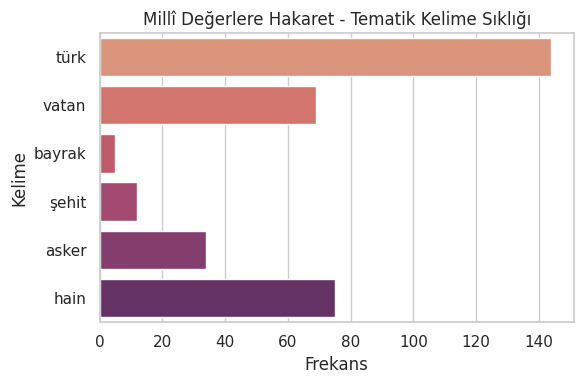

In [79]:
# Milli Deƒüerlere Hakaret temalƒ± √∂nemli kelimelerin frekansƒ±
kelimeler = ['t√ºrk', 'vatan', 'bayrak', '≈üehit', 'asker', 'hain']
frekanslar = [kategori_df['Payla≈üƒ±m'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='flare')
plt.title("Mill√Æ Deƒüerlere Hakaret - Tematik Kelime Sƒ±klƒ±ƒüƒ±")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-82-8b8c01666d92>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='mako')


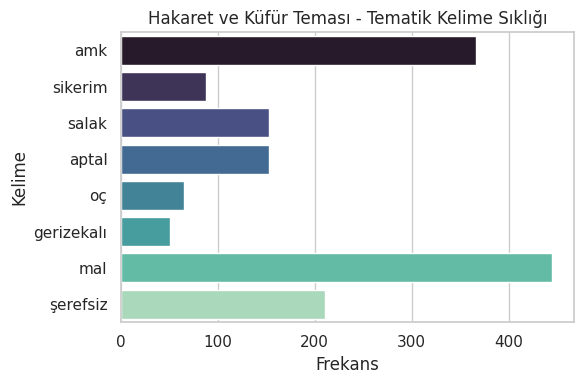

In [82]:
# Hakaret ve K√ºf√ºr temalƒ± √∂nemli kelimelerin frekansƒ±
kelimeler = ['amk', 'sikerim', 'salak', 'aptal', 'o√ß', 'gerizekalƒ±', 'mal', '≈üerefsiz']
frekanslar = [kategori_df['Payla≈üƒ±m'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='mako')
plt.title("Hakaret ve K√ºf√ºr Temasƒ± - Tematik Kelime Sƒ±klƒ±ƒüƒ±")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-83-cc64b35bbce0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='dark')


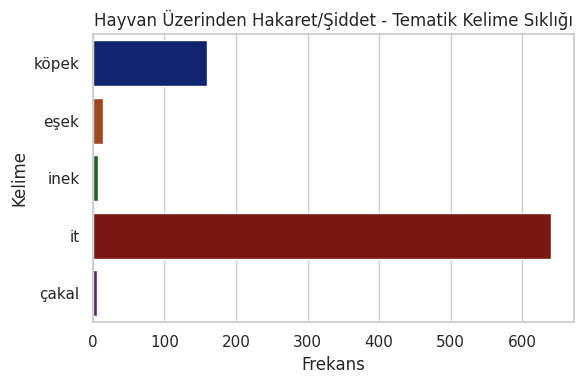

In [83]:
# Hayvan √úzerinden Hakaret/≈ûiddet temalƒ± √∂nemli kelimelerin frekansƒ±
kelimeler = ['k√∂pek', 'e≈üek', 'inek', 'it', '√ßakal']
frekanslar = [kategori_df['Payla≈üƒ±m'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='dark')
plt.title("Hayvan √úzerinden Hakaret/≈ûiddet - Tematik Kelime Sƒ±klƒ±ƒüƒ±")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-84-0202c31e8ee8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='ch:s=-.2,r=.6')


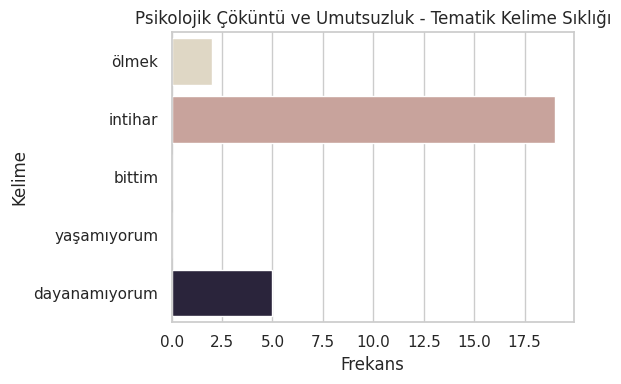

In [84]:
# Psikolojik √á√∂k√ºnt√º temalƒ± √∂nemli kelimelerin frekansƒ±
kelimeler = ['√∂lmek', 'intihar', 'bittim', 'ya≈üamƒ±yorum', 'dayanamƒ±yorum']
frekanslar = [kategori_df['Payla≈üƒ±m'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='ch:s=-.2,r=.6')
plt.title("Psikolojik √á√∂k√ºnt√º ve Umutsuzluk - Tematik Kelime Sƒ±klƒ±ƒüƒ±")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


<ipython-input-85-cfdabd0ea527>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frekanslar, y=kelimeler, palette='husl')


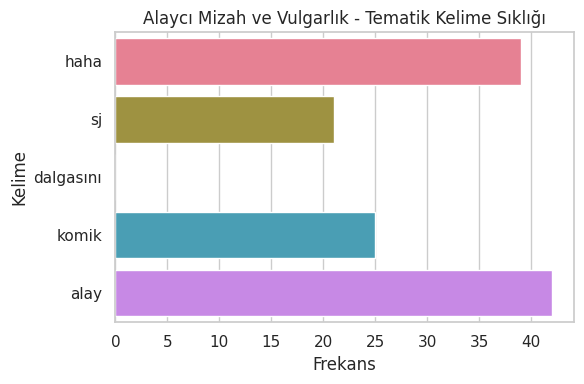

In [85]:
# Alay temalƒ± √∂nemli kelimelerin frekansƒ±
kelimeler = ['haha', 'sj', 'dalgasƒ±nƒ±', 'komik', 'alay']
frekanslar = [kategori_df['Payla≈üƒ±m'].str.lower().str.contains(k).sum() for k in kelimeler]

plt.figure(figsize=(6, 4))
sns.barplot(x=frekanslar, y=kelimeler, palette='husl')
plt.title("Alaycƒ± Mizah ve Vulgarlƒ±k - Tematik Kelime Sƒ±klƒ±ƒüƒ±")
plt.xlabel("Frekans")
plt.ylabel("Kelime")
plt.tight_layout()
plt.show()


In [71]:
# En yoƒüun kategori nedir?
en_yogun_kategori = kategori_sayim.idxmax()
en_yogun_sayi = kategori_sayim.max()

print(f"En yoƒüun kategori: '{en_yogun_kategori}' ({en_yogun_sayi} payla≈üƒ±m)")


En yoƒüun kategori: 'Diƒüer' (2159 payla≈üƒ±m)


In [72]:
# üîç Siber Zorbalƒ±k Tespiti
# Bu b√∂l√ºmde, daha √∂nce tanƒ±mlanan tematik kategorilerden √∂zellikle bireysel hakaret, cinsel k√ºf√ºr,
# kadƒ±na y√∂nelik ≈üiddet ve dini deƒüerlere saldƒ±rƒ± gibi i√ßerikler 'siber zorbalƒ±k' kapsamƒ±nda etiketlenecektir.
# Kategorilere g√∂re i√ßerikler filtrelenerek 'Zorbalƒ±k Var' veya 'Yok' olarak i≈üaretlenecektir.

In [73]:
# Hangi kategoriler siber zorbalƒ±k olarak kabul edilecek
zorbalik_kategorileri = [
    'Bireysel Hakaret ve Zorbalƒ±k',
    'Cinsel ƒ∞ma ve K√ºf√ºr',
    'Kadƒ±na ≈ûiddet ve Cinsiyet√ßilik',
    'Dini ve Milli Deƒüerlere Saldƒ±rƒ±'
]

# Yeni s√ºtun: Zorbalƒ±k i√ßeriyor mu?
kategori_df['SiberZorbalik'] = kategori_df['Kategoriler'].apply(lambda x: 'Zorbalƒ±k Var' if x in zorbalik_kategorileri else 'Yok')

# √ñzet tablo: Ka√ß payla≈üƒ±mda zorbalƒ±k var?
zorbalik_ozet = kategori_df['SiberZorbalik'].value_counts()
print(zorbalik_ozet)


SiberZorbalik
Zorbalƒ±k Var    3605
Yok             2668
Name: count, dtype: int64


<ipython-input-74-a25320f34b2b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=kategori_df, x='SiberZorbalik', palette='coolwarm')


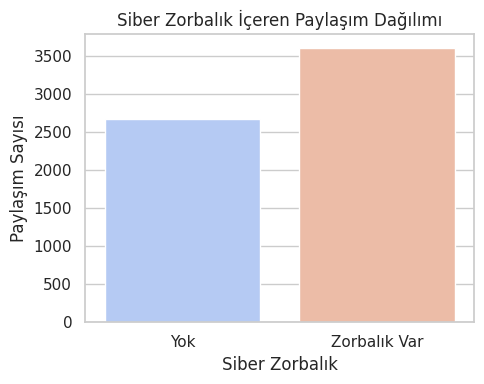

In [74]:
# Siber zorbalƒ±k daƒüƒ±lƒ±mƒ±nƒ±n g√∂rselle≈ütirilmesini yapalƒ±m
plt.figure(figsize=(5, 4))
sns.countplot(data=kategori_df, x='SiberZorbalik', palette='coolwarm')
plt.title("Siber Zorbalƒ±k ƒ∞√ßeren Payla≈üƒ±m Daƒüƒ±lƒ±mƒ±")
plt.xlabel("Siber Zorbalƒ±k")
plt.ylabel("Payla≈üƒ±m Sayƒ±sƒ±")
plt.tight_layout()
plt.show()
